In [65]:
import os
os.environ["THEANO_FLAGS"] = 'cuda.root=/usr/local/cuda,floatX=float32,device=gpu3,force_device=False'

import theano
print(theano.config.device)

import mhcflurry, seaborn, numpy, pandas, pickle, sklearn, collections, scipy, time, logging, sys
import mhcflurry.dataset
import fancyimpute

import sklearn.metrics
import sklearn.cross_validation
from collections import defaultdict
import numpy as np
import pepdata

%matplotlib inline


gpu3


In [2]:
min_peptides_to_consider_allele = 10
max_ic50 = 50000
data_dir = "../data/"

In [3]:
all_train_data = mhcflurry.dataset.Dataset.from_csv(data_dir + "bdata.2009.mhci.public.1.txt")

In [4]:
all_train_data._df

species      allele  peptide_length   cv  \
allele     peptide                                                     
ELA-A1     GSQKLTTGNCNW        None      ELA-A1              12  TBD   
           HVKDETNTTEYW        None      ELA-A1              12  TBD   
           LVEDVTNTAEYW        None      ELA-A1              12  TBD   
           RVEDKTNTAEYW        None      ELA-A1              12  TBD   
           RVEDVKNTAEYW        None      ELA-A1              12  TBD   
           RVEDVTLTAEYW        None      ELA-A1              12  TBD   
           RVEDVTNKAEYW        None      ELA-A1              12  TBD   
           RVEDVTNTAELW        None      ELA-A1              12  TBD   
           RVEDVTNTAEYL        None      ELA-A1              12  TBD   
           RVEDVTNTAEYW        None      ELA-A1              12  TBD   
           RVEDVTNTALYW        None      ELA-A1              12  TBD   
           RVEDVTNTKEYW        None      ELA-A1              12  TBD   
           RVEKVTNTAEYW        None      ELA-A1              12  TBD   
           RVLDVTNTAEYW        None      ELA-A1              12  TBD   
Gogo-B0101 RRFVNVVPTF       gorilla  Gogo-B0101              10  TBD   
           ERYLKDQQL        gorilla  Gogo-B0101               9  TBD   
           GRFKLIVLY        gorilla  Gogo-B0101               9  TBD   
           IDFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           IFFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           IKFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           ILFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           INFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           IRFPKTFGW        gorilla  Gogo-B0101               9  TBD   
           IRYPKTFGW        gorilla  Gogo-B0101               9  TBD   
           KRGILTLKY        gorilla  Gogo-B0101               9  TBD   
           KRKKAYADF        gorilla  Gogo-B0101               9  TBD   
           KRYKSIVKY        gorilla  Gogo-B0101               9  TBD   
           RRYQKSTEL        gorilla  Gogo-B0101               9  TBD   
           SRDKTIIMW        gorilla  Gogo-B0101               9  TBD   
H-2-DB     AAAAAAYAAM         mouse      H-2-DB              10  TBD   
...                             ...         ...             ...  ...   
Patr-B2401 SLYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SNYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SPYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SQYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SRYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SSYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           STYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SVYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           SYYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           TDATSILGI     chimpanzee  Patr-B2401               9  TBD   
           TDNSSPPAV     chimpanzee  Patr-B2401               9  TBD   
           TDYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           TEAMTRYSA     chimpanzee  Patr-B2401               9  TBD   
           TESTLSTAL     chimpanzee  Patr-B2401               9  TBD   
           TILGIGTVL     chimpanzee  Patr-B2401               9  TBD   
           VDFIPVENL     chimpanzee  Patr-B2401               9  TBD   
           VDILAGYGA     chimpanzee  Patr-B2401               9  TBD   
           VDKNPHNTA     chimpanzee  Patr-B2401               9  TBD   
           VDPNIRTGV     chimpanzee  Patr-B2401               9  TBD   
           VDVQYLYGV     chimpanzee  Patr-B2401               9  TBD   
           VDYLELDTI     chimpanzee  Patr-B2401               9  TBD   
           VEAQLHVWV     chimpanzee  Patr-B2401               9  TBD   
           VESENKVVI     chimpanzee  Patr-B2401               9  TBD

In [5]:
alleles = [
    #"HLA-A0201",
    # "HLA-A0301",
    # "HLA-A0203",
    "HLA-A2602",
    "HLA-A2603",
    # 'HLA-B7301',
]
all_train_data._df.allele.value_counts()[alleles]
#alleles = alleles[:1] + alleles[-1:]
#alleles = [allele for allele in all_train_data if len(all_train_data[allele].Y) >= min_peptides_to_consider_allele]

HLA-A2602    202
HLA-A2603    205
Name: allele, dtype: int64

In [6]:
def log_to_ic50(log_value):
        """
        Convert neural network output to IC50 values between 0.0 and
        self.max_ic50 (typically 5000, 20000 or 50000)
        """
        return max_ic50 ** (1.0 - log_value)

def make_scores(ic50_y, ic50_y_pred, sample_weight=None, threshold_nm=500):     
    y_pred = mhcflurry.regression_target.ic50_to_regression_target(ic50_y_pred, max_ic50)
    try:
        auc = sklearn.metrics.roc_auc_score(ic50_y <= threshold_nm, y_pred, sample_weight=sample_weight)
    except ValueError:
        auc = numpy.nan
    try:
        f1 = sklearn.metrics.f1_score(ic50_y <= threshold_nm, ic50_y_pred <= threshold_nm, sample_weight=sample_weight)
    except ValueError:
        f1 = numpy.nan
    try:
        tau = scipy.stats.kendalltau(ic50_y_pred, ic50_y)[0]
    except ValueError:
        tau = numpy.nan
    
    return dict(
        auc=auc,
        f1=f1,
        tau=tau,
    )    

    
def Xmake_scores(y, y_pred, weights=None, sample_weight=None, threshold_nm=500):
    ic50_y = log_to_ic50(y)
    ic50_y_pred = log_to_ic50(y_pred) 
    return dict(
        auc=sklearn.metrics.roc_auc_score(ic50_y <= threshold_nm, y_pred, sample_weight=sample_weight),
        f1=sklearn.metrics.f1_score(ic50_y <= threshold_nm, ic50_y_pred <= threshold_nm, sample_weight=sample_weight),
        tau=scipy.stats.kendalltau(y_pred, y)[0],
    )    

def mean_with_std(grouped_column, decimals=3):
    pattern = "%%0.%df" % decimals
    return pandas.Series([
        (pattern + " +/ " + pattern) % (m, s) if not pandas.isnull(s) else pattern % m
        for (m, s) in zip(grouped_column.mean(), grouped_column.std())
    ], index = grouped_column.mean().index)



def Xcollapse_9mer_affinities(Y_9mer_true, Y_9mer_pred, original_peptides):
    """
    Parameters
    ----------
    Y_9mer_true : np.array of float
        True regression target values for 9mers extracted from longer/shorter peptides
    
    Y_9mer_pred : np.array of float
        Predicted values for 9mers
    
    original_peptides : np.array of str
        Original peptides of varying length that 9mers were extracted from.
    """
    # collapse multiple 9mer predictions and measured values into 
    # smaller set of predictions for peptides of varying lengths
    peptide_to_true_affinity_dict = defaultdict(list)
    peptide_to_predicted_affinity_dict = defaultdict(list)
    for i, p in enumerate(original_peptides):
        peptide_to_true_affinity_dict[p].append(Y_9mer_true[i])
        peptide_to_predicted_affinity_dict[p].append(Y_9mer_pred[i])

    unique_peptides = list(sorted(set(peptide_to_predicted_affinity_dict.keys())))
    print("-- # unique peptides = %d" % (len(unique_peptides),))
    Y_true = np.array([
            np.mean(peptide_to_true_affinity_dict[p]) for p in unique_peptides ])
    Y_pred = np.array([
            np.mean(peptide_to_predicted_affinity_dict[p]) for p in unique_peptides])
    return Y_true, Y_pred

In [92]:
dropout_probabilities = [0.5]

#embedding_output_dims = [32]
embedding_output_dims = [4, 32]

#layer_sizes = [[4], [8], [16], [64], [128]]
layer_sizes_list = [[4], [64], [128], [256]]

activations = ["tanh"]

models_params_list = []
for n_training_epochs in [250, 500, 1000]:
    for impute in [False, True]:
        for pretrain_decay in ["1 / (1+epoch)**2"]: #"numpy.exp(-epoch)"]:
            for fraction_negative in [.10]:
                for dropout_probability in dropout_probabilities:
                    for embedding_output_dim in embedding_output_dims:
                        for layer_sizes in layer_sizes_list:
                            for activation in activations:
                                models_params_list.append(dict(
                                    n_training_epochs=n_training_epochs,
                                    impute=impute,
                                    pretrain_decay=pretrain_decay,
                                    fraction_negative=fraction_negative,
                                    dropout_probability=dropout_probability,  
                                    embedding_output_dim=embedding_output_dim,
                                    layer_sizes=layer_sizes,
                                    activation=activation))

print("%d models" % len(models_params_list))
models_params_explored = set.union(*[set(x) for x in models_params_list])
models_params_explored


48 models


{'activation',
 'dropout_probability',
 'embedding_output_dim',
 'fraction_negative',
 'impute',
 'layer_sizes',
 'n_training_epochs',
 'pretrain_decay'}

In [8]:
reload(mhcflurry.class1_binding_predictor)
reload(mhcflurry)


<module 'mhcflurry' from '/home/tim/sinai/git/mhcflurry/mhcflurry/__init__.pyc'>

In [15]:
gbmr4_transformer = pepdata.reduced_alphabet.make_alphabet_transformer("gbmr4")
def default_projector(peptide):
    """
    Given a peptide, return a list of projections for it. The projections are:
        - the gbmr4 reduced representation
        - for all positions in the peptide, the peptide with a "." replacing the residue at that position
    
    Parameters
    ----------
    peptide : string
    
    Returns
    ----------
    string list
    """
    def projections(peptide, edit_distance=1):
        if edit_distance == 0:
            return set([peptide])
        return set.union(*[
                projections(p, edit_distance - 1)
                for p in (peptide[0:i] + "." + peptide[(i+1):] for i in range(len(peptide)))
        ])
    return sorted(projections(peptide)) + [gbmr4_transformer(peptide)]

def similar_peptides(set1, set2, projector=default_projector):
    """
    Given two sets of peptides, return a list of the peptides whose reduced representations
    are found in both sets.
    
    Parameters
    ----------
    projector : (string -> string) or (string -> string list)
        Function giving projection(s) of a peptide
        
    Returns
    ----------
    string list
        
    """
    result = collections.defaultdict(lambda: ([], []))
    for (index, peptides) in enumerate([set1, set2]):
        for peptide in peptides:
            projections = projector(peptide)
            if not isinstance(projections, list):
                projections = [projections]
            for projection in projections:
                result[projection][index].append(peptide)
    
    common = set()
    for (peptides1, peptides2) in result.values():
        if peptides1 and peptides2:
            common.update(peptides1 + peptides2)

    return sorted(common)


In [27]:
imputer = fancyimpute.MICE(n_imputations=50, n_burn_in=5, n_nearest_columns=25)

In [16]:
# allele -> list of (train set, imputed train set, test set) for each fold
n_folds = 3
cv_splits = {}
for allele in alleles:
    print("Allele: %s" % allele)
    cv_iter = all_train_data.cross_validation_iterator(allele, n_folds=n_folds, shuffle=True)
    triples = []
    for (all_allele_train_split, full_test_split) in cv_iter:
        peptides_to_remove = similar_peptides(
            all_allele_train_split.get_allele(allele).peptides,
            full_test_split.get_allele(allele).peptides
        )
        print("Peptides to remove: %d: %s" % (len(peptides_to_remove), str(peptides_to_remove)))
        if peptides_to_remove:
            test_split = full_test_split.drop_allele_peptide_lists(
                [allele] * len(peptides_to_remove),
                peptides_to_remove)
            print("After dropping similar peptides, test size %d -> %d" % (len(full_test_split), len(test_split)))
        else:
            test_split = full_test_split
        imputed_train_split = all_allele_train_split.impute_missing_values(
            imputer,
            min_observations_per_peptide=2,
            min_observations_per_allele=2).get_allele(allele)
        train_split = all_allele_train_split.get_allele(allele)
        triples.append((train_split, imputed_train_split, test_split))
    cv_splits[allele] = triples

Allele: HLA-A2602
Peptides to remove: 10: ['DILASIIDY', 'DTTTDISKY', 'EVIEQWHSL', 'KQWGWFALL', 'QVGIFLICK', 'REMGIVDLL', 'RRMATTFTF', 'RRYTRRISL', 'TTAKAMEQM', 'TVGYMYIMK']
After dropping similar peptides, test size 68 -> 63
Dropping 12246 peptides with <2 observations
Dropping 9 alleles with <2 observations: ['ELA-A1', 'HLA-B2701', 'HLA-B3508', 'HLA-B44', 'HLA-E0101', 'Mamu-B04', 'Patr-A0602', 'Patr-B0901', 'Patr-B1701']
[MICE] Completing matrix with shape (19292, 97)
[MICE] Starting imputation round 1/110, elapsed time 0.020
[MICE] Starting imputation round 2/110, elapsed time 1.569
[MICE] Starting imputation round 3/110, elapsed time 3.111
[MICE] Starting imputation round 4/110, elapsed time 4.665
[MICE] Starting imputation round 5/110, elapsed time 6.208
[MICE] Starting imputation round 6/110, elapsed time 7.737
[MICE] Starting imputation round 7/110, elapsed time 9.265
[MICE] Starting imputation round 8/110, elapsed time 10.791
[MICE] Starting imputation round 9/110, elapsed time 

In [57]:
cv_splits_downsampled = {}
for allele in ["HLA-A0201"]:
    print("Allele: %s" % allele)
    for size in [10, 250, 1000]:
        triples = []
        for replica in range(1):
            train_peptides = set(numpy.random.choice(all_train_data.get_allele(allele).peptides, size, replace=False))
            full_test_peptides = [x for x in all_train_data.get_allele(allele).peptides if x not in train_peptides]
            peptides_to_remove = set(similar_peptides(train_peptides, full_test_peptides))
            test_peptides = [x for x in full_test_peptides if x not in peptides_to_remove]
            #print("Removing peptides: %s" % peptides_to_remove)
            print("test size %d -> %d after removing" % (len(full_test_peptides), len(test_peptides)))

            train_dataset = all_train_data.drop_allele_peptide_lists(
                [allele] * len(full_test_peptides), sorted(full_test_peptides))
            test_dataset = all_train_data.drop_allele_peptide_pairs(
                [(allele, peptide) for peptide in sorted(peptides_to_remove) + sorted(train_peptides)])

            imputed_train_split = train_dataset.impute_missing_values(
                imputer,
                min_observations_per_peptide=2,
                min_observations_per_allele=2)

            triples.append((
                    train_dataset.get_allele(allele),
                    imputed_train_split.get_allele(allele),
                    test_dataset.get_allele(allele)))
        cv_splits_downsampled["%s-%d" % (allele, size)] = triples
                

Allele: HLA-A0201
test size 9555 -> 9492 after removing
Dropping 10067 peptides with <2 observations
Dropping 9 alleles with <2 observations: ['ELA-A1', 'HLA-B2701', 'HLA-B3508', 'HLA-B44', 'HLA-E0101', 'Mamu-B04', 'Patr-A0602', 'Patr-B0901', 'Patr-B1701']
[MICE] Completing matrix with shape (18850, 97)
[MICE] Starting imputation round 1/55, elapsed time 0.020
[MICE] Starting imputation round 2/55, elapsed time 0.380
[MICE] Starting imputation round 3/55, elapsed time 0.729
[MICE] Starting imputation round 4/55, elapsed time 1.084
[MICE] Starting imputation round 5/55, elapsed time 1.440
[MICE] Starting imputation round 6/55, elapsed time 1.794
[MICE] Starting imputation round 7/55, elapsed time 2.184
[MICE] Starting imputation round 8/55, elapsed time 2.599
[MICE] Starting imputation round 9/55, elapsed time 2.962
[MICE] Starting imputation round 10/55, elapsed time 3.363
[MICE] Starting imputation round 11/55, elapsed time 3.803
[MICE] Starting imputation round 12/55, elapsed time 4.

In [60]:
cv_splits_downsampled

{'HLA-A0201-10': [(Dataset(n=10, alleles=['HLA-A0201']),
   Dataset(n=18850, alleles=['HLA-A0201']),
   Dataset(n=9492, alleles=['HLA-A0201']))],
 'HLA-A0201-1000': [(Dataset(n=1000, alleles=['HLA-A0201']),
   Dataset(n=18894, alleles=['HLA-A0201']),
   Dataset(n=6532, alleles=['HLA-A0201']))],
 'HLA-A0201-250': [(Dataset(n=250, alleles=['HLA-A0201']),
   Dataset(n=18858, alleles=['HLA-A0201']),
   Dataset(n=8482, alleles=['HLA-A0201']))]}

In [61]:
cv_splits_downsampled["HLA-A0201-250"][0][0]._df.peptide.nunique()

250

In [ ]:
cv_df = defaultdict(list)
start = time.time()

for (allele, triples) in cv_splits_downsampled.items():
    print("Allele: %s" % allele)
            
    #cv = sklearn.cross_validation.LabelKFold(original_peptides, n_folds = 3)
    for (fold_num, (subset_train, subset_impute, subset_test)) in enumerate(triples):
        print("-- fold #%d/3" % (fold_num + 1,))
        
        np.random.shuffle(models_params_list)
        for (i, original_model_params) in enumerate(models_params_list):
            model_params = dict(original_model_params)
            fraction_negative = model_params["fraction_negative"]
            del model_params["fraction_negative"]
            
            impute = model_params["impute"]
            del model_params["impute"]
            
            n_training_epochs = model_params["n_training_epochs"]
            del model_params["n_training_epochs"]
            
            pretrain_decay = model_params["pretrain_decay"]
            del model_params["pretrain_decay"] 
            
            print("%10s fold %3d [%3d / %3d] train_size=%d test_size=%d impute=%s model=%s" %
                  (allele, fold_num, i, len(models_params_list), len(subset_train), len(subset_test), impute, original_model_params))
            sys.stdout.flush()
            
            predictor = mhcflurry.Class1BindingPredictor.from_hyperparameters(max_ic50=max_ic50, **model_params)

            fit_time = -time.time()
            predictor.fit_dataset(
                subset_train,
                pretrain_decay=lambda epoch: eval(pretrain_decay, {'epoch': epoch, 'numpy': numpy}),
                pretraining_dataset=subset_impute if impute else None,
                verbose=False,
                batch_size=128,
                n_training_epochs=n_training_epochs,
                n_random_negative_samples=int(fraction_negative * len(subset_train)))
            fit_time += time.time()
            
            train_predictions = predictor.predict(subset_train.peptides)
            test_predictions = predictor.predict(subset_test.peptides)
            
            cv_df["allele"].append(allele)
            cv_df["train_size"].append(len(subset_train))
            cv_df["test_size"].append(len(subset_test))

            cv_df["model_params"].append(original_model_params)
            cv_df["fit_time"].append(fit_time)

            for (param, param_value) in original_model_params.items():
                cv_df[param].append(param_value)
            
            for (key, value) in make_scores(subset_train.affinities, train_predictions).items():
                cv_df["train_%s" % key].append(value)
                print("train %s: %f" % (key, value))
            
            for (key, value) in make_scores(
                    subset_test.affinities, 
                    test_predictions).items():
                cv_df["test_%s" % key].append(value)
                print("test %s: %f" % (key, value))
            
            best_model_index = sorted(cv_df)


cv_df = pandas.DataFrame(cv_df)
cv_df["layer0_size"] = [x[0] for x in cv_df.layer_sizes]
print(time.time() - start)
cv_df

Allele: HLA-A0201-1000
-- fold #1/3
HLA-A0201-1000 fold   0 [  0 /  48] train_size=1000 test_size=6532 impute=False model={'pretrain_decay': '1 / (1+epoch)**2', 'dropout_probability': 0.5, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh', 'impute': False, 'embedding_output_dim': 4, 'n_training_epochs': 250}


In [63]:
cv_df = pandas.DataFrame(cv_df)
cv_df["layer0_size"] = [x[0] for x in cv_df.layer_sizes]
cv_df

,activation,allele,dropout_probability,embedding_output_dim,fit_time,fraction_negative,impute,layer_sizes,model_params,pretrain_decay,test_auc,test_f1,test_size,test_tau,train_auc,train_f1,train_size,train_tau,layer0_size
0,tanh,HLA-A0201-1000,0.5,32,9.020235,0.10,False,[4],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.944129,0.781538,6532,0.575135,0.954311,0.826797,1000,0.639283,4
1,tanh,HLA-A0201-1000,0.5,32,21.483086,0.25,True,[128],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.944119,0.788403,6532,0.579707,0.966072,0.859903,1000,0.672694,128
2,tanh,HLA-A0201-1000,0.5,32,24.404643,0.25,False,[128],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943457,0.787275,6532,0.577656,0.957648,0.847134,1000,0.653371,128
3,tanh,HLA-A0201-1000,0.5,32,35.635757,0.00,True,[128],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.942964,0.788931,6532,0.574669,0.973811,0.876582,1000,0.693179,128
4,tanh,HLA-A0201-1000,0.5,32,17.244989,0.00,True,[4],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.942841,0.799037,6532,0.569696,0.954603,0.851330,1000,0.637638,4
5,tanh,HLA-A0201-1000,0.5,32,15.595821,0.00,False,[4],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.942604,0.782513,6532,0.571389,0.954316,0.831461,1000,0.639466,4
6,tanh,HLA-A0201-1000,0.5,32,17.243771,0.25,True,[4],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943885,0.772311,6532,0.577048,0.950923,0.811980,1000,0.637638,4
7,tanh,HLA-A0201-1000,0.5,32,21.756550,0.10,True,[128],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.943979,0.785000,6532,0.577417,0.971031,0.874598,1000,0.688316,128
8,tanh,HLA-A0201-1000,0.5,32,22.730584,0.10,False,[128],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943646,0.789589,6532,0.576350,0.959904,0.856240,1000,0.655590,128
9,tanh,HLA-A0201-1000,0.5,32,23.225753,0.10,False,[128],"{u'pretrain_decay': u'numpy.exp(-epoch)', u'im...",numpy.exp(-epoch),0.943822,0.786249,6532,0.577494,0.959740,0.841935,1000,0.658903,128


In [81]:
cv_df["model_string"] = [str(x) for x in cv_df.model_params]
cv_df.groupby(["model_string", "train_size"]).test_auc.mean().sort(inplace=False, ascending=False).to_frame()

/home/tim/anaconda2/envs/standard-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


,,test_auc
model_string,train_size,
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [64], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.944920
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [64], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.944612
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [256], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.944024
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.943817
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [256], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.943776
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.943569
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [128], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.943261
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [128], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.943004
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 4, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh'}",1000,0.924926


In [82]:
cv_df.groupby(["model_string"]).test_auc.mean().sort(inplace=False, ascending=False).to_frame()

/home/tim/anaconda2/envs/standard-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


,test_auc
model_string,
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.875597
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [256], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.872666
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [64], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.867162
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [128], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.852075
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [128], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.829037
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 4, 'layer_sizes': [128], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.817082
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 4, 'layer_sizes': [4], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.815144
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': True, 'dropout_probability': 0.5, 'embedding_output_dim': 4, 'layer_sizes': [256], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.814963
"{'pretrain_decay': '1 / (1+epoch)**2', 'impute': False, 'dropout_probability': 0.5, 'embedding_output_dim': 32, 'layer_sizes': [256], 'fraction_negative': 0.1, 'activation': 'tanh'}",0.814917


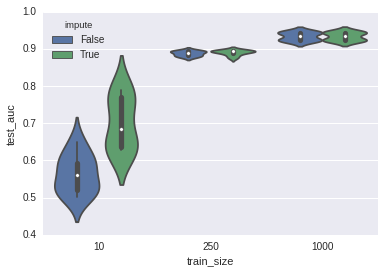

In [85]:
seaborn.violinplot(data=cv_df, x="train_size", y="test_auc", hue="impute")

In [91]:
cv_df.groupby(["train_size", "layer0_size"]).test_auc.max()

train_size  layer0_size
10          4              0.788338
            64             0.766717
            128            0.720564
            256            0.778861
250         4              0.894884
            64             0.893989
            128            0.895955
            256            0.895112
1000        4              0.943817
            64             0.944920
            128            0.943261
            256            0.944024
Name: test_auc, dtype: float64

In [89]:
cv_df.groupby(["train_size", "impute"]).test_auc.max()

train_size  impute
10          False     0.648763
            True      0.788338
250         False     0.895087
            True      0.895955
1000        False     0.944612
            True      0.944920
Name: test_auc, dtype: float64

In [84]:
cv_df.sort("test_auc", ascending=False)

/home/tim/anaconda2/envs/standard-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,activation,allele,dropout_probability,embedding_output_dim,fit_time,fraction_negative,impute,layer_sizes,model_params,pretrain_decay,test_auc,test_f1,test_size,test_tau,train_auc,train_f1,train_size,train_tau,layer0_size,model_string
14,tanh,HLA-A0201-1000,0.5,32,13.426505,0.1,True,[64],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.944920,0.792123,6532,0.578521,0.958178,0.846645,1000,0.649511,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
5,tanh,HLA-A0201-1000,0.5,32,12.238065,0.1,False,[64],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.944612,0.789052,6532,0.577878,0.957548,0.845161,1000,0.648197,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
6,tanh,HLA-A0201-1000,0.5,32,15.937529,0.1,True,[256],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.944024,0.774943,6532,0.578387,0.963812,0.844517,1000,0.667076,256,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
9,tanh,HLA-A0201-1000,0.5,32,10.549995,0.1,False,[4],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943817,0.774866,6532,0.574753,0.954256,0.812500,1000,0.640486,4,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
13,tanh,HLA-A0201-1000,0.5,32,14.192804,0.1,False,[256],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943776,0.800000,6532,0.575957,0.961420,0.860720,1000,0.662286,256,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
2,tanh,HLA-A0201-1000,0.5,32,11.623836,0.1,True,[4],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943569,0.792068,6532,0.573797,0.953553,0.832000,1000,0.639674,4,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
7,tanh,HLA-A0201-1000,0.5,32,13.778689,0.1,False,[128],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943261,0.788530,6532,0.574798,0.959685,0.863492,1000,0.654281,128,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
3,tanh,HLA-A0201-1000,0.5,32,10.565188,0.1,True,[128],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.943004,0.777246,6532,0.574835,0.962954,0.857143,1000,0.663518,128,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
8,tanh,HLA-A0201-1000,0.5,4,11.624597,0.1,False,[4],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.924926,0.661178,6532,0.550081,0.927693,0.708861,1000,0.595068,4,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."
11,tanh,HLA-A0201-1000,0.5,4,13.419750,0.1,False,[256],"{u'pretrain_decay': u'1 / (1+epoch)**2', u'imp...",1 / (1+epoch)**2,0.924763,0.677850,6532,0.551431,0.926912,0.726950,1000,0.593954,256,"{'pretrain_decay': '1 / (1+epoch)**2', 'impute..."


In [ ]:
cv_df["combined"] = cv_df.test_auc + cv_df.test_f1 + cv_df.test_tau

In [ ]:
cv_df_str = cv_df.copy()
print(cv_df_str.columns)
del cv_df_str['model_params']
del cv_df_str['fit_time']

for col in ["layer_sizes"]:
    cv_df_str[col] = [str(x) for x in cv_df_str[col]]
summary = cv_df_str.groupby(list(cv_df_str.columns[:6])).mean() #.reset_index()
summary.sort("combined", ascending=False, inplace=True)
summary.to_csv("../data/cv_hla0201_summary_128.csv")

In [ ]:
cv_df.sort("combined", ascending=False, inplace=True)
cv_df

In [ ]:
cv_df = pandas.DataFrame(cv_df)
cv_df["layer0_size"] = [x[0] for x in cv_df.layer_sizes]
cv_df

In [ ]:
cv_df.to_csv("cv5.csv")

In [ ]:
group_columns = ["allele", "allele_size", "impute"]
group_columns.extend(models_params_explored)
group_columns.append("layer0_size")
group_columns.remove("layer_sizes")
print(mean_with_std(cv_df.groupby(group_columns).test_auc)) #.sort(inplace=False, ascending=False)



In [ ]:
def best_by(score):
    means = cv_df.groupby(group_columns)[score].mean().reset_index()
    max_rows = []
    for allele in means.allele.unique():
        max_rows.append(means.ix[means.allele == allele][score].argmax())
    return means.ix[max_rows]

In [ ]:
best_by('test_auc')


In [ ]:
best_by('test_tau')

In [ ]:
best_by('test_f1')